In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from tensorflow.keras.metrics import Precision, Recall

import datetime
import json
from os import write
import re
import subprocess
import urllib.parse

from flask import (Flask, Response, escape, make_response, render_template,
                   request)
from werkzeug.routing import BaseConverter
import numpy as np
from keras.models import load_model

from keras import backend as K
import urllib.parse
import pprint
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

In [2]:
%cd /content/drive/MyDrive/WAffle/

/content/drive/MyDrive/WAffle


In [3]:
df = pd.read_csv('Dataset/cisc_database/test_data.csv')
df.head()

,URL,Target
0,http://localhost:8080/tienda1/publico/producto...,0
1,http://localhost:8080/tienda1/publico/miembros...,0
2,http://localhost:8080/tienda1/global/menum.jsp,0
3,http://localhost:8080/tienda1/miembros/editar....,0
4,http://localhost:8080/tienda1/publico/autentic...,0


In [4]:
evaluation = pd.read_csv('Dataset/cisc_database/test_data.csv')
evaluation.head()

,URL,Target
0,http://localhost:8080/tienda1/publico/producto...,0
1,http://localhost:8080/tienda1/publico/miembros...,0
2,http://localhost:8080/tienda1/global/menum.jsp,0
3,http://localhost:8080/tienda1/miembros/editar....,0
4,http://localhost:8080/tienda1/publico/autentic...,0


In [5]:
model = load_model('./model_dir/model.h5')

In [6]:
with open("denylist.txt") as f:
  denylist = [s.strip() for s in f.readlines()]

In [7]:
# 定義済みのシグネチャを参照したパターンマッチング
def signature(url):  
  path = url.strip()[22:]
  for val in denylist:
    m = re.match(val, path, re.IGNORECASE)
    if m != None :
      return 1
  return 0

In [8]:
import urllib.parse
def url_decode(encoded_URL):
  return urllib.parse.unquote(encoded_URL)

In [9]:
def load_data(urls, max_length=1000):
    urls = [s.lower() for s in urls]
    url_list = []
    for url in urls:
        # url decode
        decoded_url = url_decode(url)
        # unicode encode
        encoded_url = [ord(x) for x in str(decoded_url).strip()]
        encoded_url = encoded_url[:max_length]
        url_len = len(encoded_url)
        if url_len < max_length:
            # zero padding
            encoded_url += ([0] * (max_length - url_len))
        url_list.append((encoded_url))
    # convert to numpy array
    url_list = np.array(url_list)
    return url_list

In [10]:
def create_label(labels):
  class_list = [x for x in labels]
  classes = np.array(class_list)
  return classes

In [11]:
X_test, y_test = df['URL'], df['Target']

In [12]:
test_data = load_data(X_test)

In [13]:
print(test_data)

[[104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 ...
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]]


In [14]:
test_classes = create_label(y_test)

In [15]:
print(test_classes)

[0 0 0 ... 1 0 0]


# Evaluate

In [16]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, test_classes, verbose=2)

print("test_loss: ", test_loss)
print("test_accuracy: ", test_accuracy)
print("test_precision: ", test_precision)
print("test_recall: ", test_recall)
#print("binary_accuracy: ", binary_accuracy)
#print("categorical_accuracy:", categorical_accuracy)

191/191 - 5s - loss: 0.2423 - accuracy: 0.8636 - precision_1: 0.7573 - recall_1: 0.9934
test_loss:  0.2423277050256729
test_accuracy:  0.8635991215705872
test_precision:  0.757287323474884
test_recall:  0.9933671355247498


In [17]:
def matching(urls):
  y_match = []
  for url in urls:
    url = url.strip()[22:]
    y_match.append(signature(url))
  y_match = pd.Series(y_match)
  return y_match

In [18]:
urls = evaluation['URL']
urls

0       http://localhost:8080/tienda1/publico/producto...
1       http://localhost:8080/tienda1/publico/miembros...
2         http://localhost:8080/tienda1/global/menum.jsp 
3       http://localhost:8080/tienda1/miembros/editar....
4       http://localhost:8080/tienda1/publico/autentic...
                              ...                        
6102    http://localhost:8080/tienda1/publico/autentic...
6103    http://localhost:8080/tienda1/publico/producto...
6104    http://localhost:8080/tienda1/publico/caracter...
6105    http://localhost:8080/tienda1/publico/autentic...
6106    http://localhost:8080/tienda1/publico/producto...
Name: URL, Length: 6107, dtype: object

In [19]:
y_match = matching(urls)
y_match

0       0
1       0
2       0
3       0
4       0
       ..
6102    0
6103    0
6104    0
6105    0
6106    0
Length: 6107, dtype: int64

In [20]:
# denylistで防げた数
sum(y_match)

35

In [21]:
y_true = evaluation['Target']
y_true

0       0
1       0
2       0
3       0
4       0
       ..
6102    1
6103    1
6104    1
6105    0
6106    0
Name: Target, Length: 6107, dtype: int64

In [22]:
evaluation['y_match'] = y_match
evaluation.head()

,URL,Target,y_match
0,http://localhost:8080/tienda1/publico/producto...,0,0
1,http://localhost:8080/tienda1/publico/miembros...,0,0
2,http://localhost:8080/tienda1/global/menum.jsp,0,0
3,http://localhost:8080/tienda1/miembros/editar....,0,0
4,http://localhost:8080/tienda1/publico/autentic...,0,0


In [23]:
y_pred = model.predict(test_data)

In [24]:
evaluation['y_pred'] = y_pred
evaluation.head()

,URL,Target,y_match,y_pred
0,http://localhost:8080/tienda1/publico/producto...,0,0,0.002663
1,http://localhost:8080/tienda1/publico/miembros...,0,0,0.002899
2,http://localhost:8080/tienda1/global/menum.jsp,0,0,0.002620
3,http://localhost:8080/tienda1/miembros/editar....,0,0,0.764174
4,http://localhost:8080/tienda1/publico/autentic...,0,0,0.759452


In [25]:
evaluation['y_pred'] = evaluation['y_pred'].apply(lambda x:1 if x >= 0.5 else 0)
evaluation.head()

,URL,Target,y_match,y_pred
0,http://localhost:8080/tienda1/publico/producto...,0,0,0
1,http://localhost:8080/tienda1/publico/miembros...,0,0,0
2,http://localhost:8080/tienda1/global/menum.jsp,0,0,0
3,http://localhost:8080/tienda1/miembros/editar....,0,0,1
4,http://localhost:8080/tienda1/publico/autentic...,0,0,1


In [26]:
print(sum(evaluation['Target']))
print(sum(evaluation['y_pred']))

2563
3362


In [27]:
evaluation['WAffle'] = (evaluation['y_pred'] | evaluation['y_match'])
evaluation.head()

,URL,Target,y_match,y_pred,WAffle
0,http://localhost:8080/tienda1/publico/producto...,0,0,0,0
1,http://localhost:8080/tienda1/publico/miembros...,0,0,0,0
2,http://localhost:8080/tienda1/global/menum.jsp,0,0,0,0
3,http://localhost:8080/tienda1/miembros/editar....,0,0,1,1
4,http://localhost:8080/tienda1/publico/autentic...,0,0,1,1


In [28]:
print(accuracy_score(evaluation['Target'], evaluation['WAffle']))
print(precision_score(evaluation['Target'], evaluation['WAffle']))
print(recall_score(evaluation['Target'], evaluation['WAffle']))

0.8635991485180939
0.7572873289708507
0.9933671478735856


In [29]:
print(classification_report(evaluation['Target'], evaluation['WAffle']))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      3544
           1       0.76      0.99      0.86      2563

    accuracy                           0.86      6107
   macro avg       0.88      0.88      0.86      6107
weighted avg       0.89      0.86      0.86      6107



In [30]:
d = classification_report(evaluation['Target'], evaluation['WAffle'], output_dict=True)
pprint.pprint(d)

{'0': {'f1-score': 0.8675465097789793,
       'precision': 0.9938069216757741,
       'recall': 0.7697516930022573,
       'support': 3544},
 '1': {'f1-score': 0.8594092827004219,
       'precision': 0.7572873289708507,
       'recall': 0.9933671478735856,
       'support': 2563},
 'accuracy': 0.8635991485180939,
 'macro avg': {'f1-score': 0.8634778962397006,
               'precision': 0.8755471253233125,
               'recall': 0.8815594204379215,
               'support': 6107},
 'weighted avg': {'f1-score': 0.8641314593446674,
                  'precision': 0.8945438275047051,
                  'recall': 0.8635991485180939,
                  'support': 6107}}


In [31]:
cm = confusion_matrix(evaluation['Target'], evaluation['WAffle'])
print(cm)

[[2728  816]
 [  17 2546]]


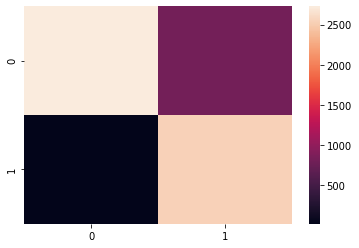

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm)

In [33]:
evaluation.to_csv('./Dataset/cisc_database/evaluation.csv')